# Visualización de tratamientos de radioterapia
------

Para la prescripción, planificación y valoración de un tratamiento de radioterapia es necesario conocer la anatomía del paciente, y la descripción de los haces empleados y de la distribución de dosis generada.

## Estudio de CT

Los datos anatómicos para la *simulación* del tratamiento del paciente se adquieren mediante un estudio de tomografía computerizada *CT* con el paciente inmobilizaddo en una postura que sea reproducible a lo largo del tratamiento.

Los volúmenes relevantes para el tratamiento se escanean mediante cortes axiales que permiten realizar una reconstrucción tridimensional del paciente.

Visualizamos una reconstrucción de una paciente de carcinoma de mama.

Comenzamos yendo al directorio que contiene los datos del estudio de la paciente e importando los módulos necesarios. 

En este cuaderno utilizaremos dos librerías específicas para la visualización y evaluación de planes de radioterapia: `scikit-rt` y `dicompyler-core` 

In [1]:
%cd ..

/Users/cesar/Documents/Development/GitHub/rtviewer


In [2]:
# Librerias específicas de radioterapia
from skrt import Image, StructureSet, Patient
from dicompylercore import dicomparser, dvh, dvhcalc

# La libreria general DICOM
import pydicom as dcm
# Manejo de listas de archivos
from glob import glob
# Otras librerias para facilitar la visualización
from matplotlib import pyplot as plt
import ipywidgets as wdg
%matplotlib widget

Leemos el estudio CT

In [3]:
im = Image('patients/TestMamaDer001/20230116_095704/CT/20230116_095704')

En la siguiente figura es posible ajustando las barras de desplazamiento navegar por la anatomía de la paciente.

Se puede apreciar que la paciente está situada con los brazos levantados para alejarlos de la región de tratamiento. Esto se consigue mediante unos inmovilizadores en los que la paciente apoya los brazos y los antebrazos en posiciones ajustables y reproducibles que faciliten el confort de la paciente. También es visible que la paciente tiene apoyada la espalda sobre un soporte completamente plano.

En la posición de partida se pueden apreciar en el corte axial la posición de la cicatriz de la operación indicada mediante una marca radioopaca. El resto de puntos brillantes en el estudio son marcas externas relativas al posicionamiento del paciente que se utilizan para reproducir su posición y establecer un marco de coordenadas al que referir el tratamiento.

In [4]:
@wdg.interact(x=(-200, 200), y=(-400, 0), z=(-50, 280)) 
def view3D(x, y, z):
    fig, axd = plt.subplot_mosaic([['ax', 'ax'], ['sg', 'cr']], figsize=[10,10])
    im.plot('x-y', ax=axd['ax'], pos=z, show=False, title='Vista axial')
    im.plot('y-z', ax=axd['sg'], pos=x, show=False, title='Vista sagital')
    im.plot('x-z', ax=axd['cr'], pos=y, title='Vista coronal')

interactive(children=(IntSlider(value=0, description='x', max=200, min=-200), IntSlider(value=-200, descriptio…

En la discusión que sigue solo nos referiremos a los planos axiales recordando que otras vistas son posible modificando el primer argumento de las funciones de visualización. Por defecto este argumento asume proyección 'x-y', planos axiales.

In [5]:
@wdg.interact(z=(-50, 280))
def axim(z):
    # Selcción de orientación de los planos  
    ## 'x-y' Axial
    ## 'x-z' Coronal
    ## 'y-z' Sagital  
    im.plot('x-y', pos = z, figsize=8) 

interactive(children=(IntSlider(value=115, description='z', max=280, min=-50), Output()), _dom_classes=('widge…

El estudio de CT se adquirió con cortes cada 3 mm. La visualización muestra el plano más cercano al valor indicado por el parámetro `pos`.  

## Estructuras

Los volumenes relevantes para la planificación, sean bien objetivos o bien regiones de interés, se tienen que delimitar sobre el estudio CT de simulación.

Las imágenes se tienen que segmentar mediante procesos manuales o semiautomáticos. Estos últimos utilizan procedimientos de base de conocimiento que se ha tenido que establecer previamente mediante procesos manuales.

Leemos el conjunto de estructuras presentes en el estudio

In [6]:
ss = StructureSet('patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm')

Los conjuntos de estructuras se visualizan asociándolos a la imagen a partir de la que han sido generados

In [7]:
im.add_structure_set(ss)

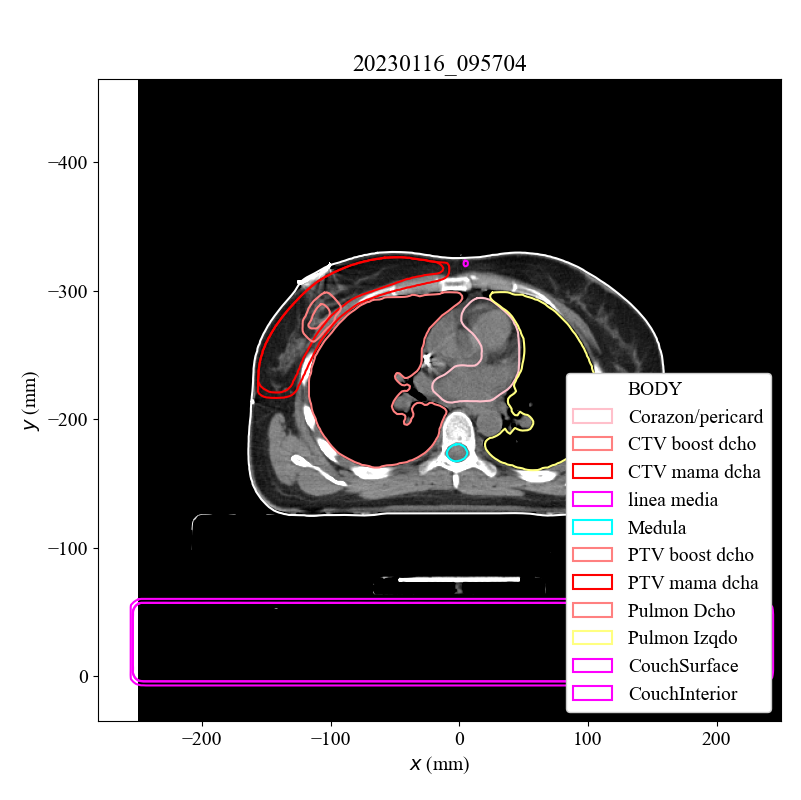

In [8]:
im.plot(rois='all', pos=115, legend=True, legend_loc='lower right', figsize=8)

Para la planificación son relevantes de estas estructuras el contorno exterior (BODY) y la modelo de la mesa (COUCH). El BODY restringe a los puntos en su interior el cálculo de interacciones. Cualquier voxel externo en términos físicos se considera vacío a excepción de los volúmenes COUCH que se fuerzan sus densidades a las correspondientes a los materiales con los que están hechos los elementos de soporte del acelerador.

Por simplificar del resto de estructuras solo consideraremos los PTVs, volúmenes de objetivos de la prescripción, y como región de interés el pulmón ipsilateral, en este caso el pulmón derecho. Para entender que se trata del pulmón derecho del paciente consideresé que el paciente está situado como si sus pies estuvieran saliendo de la pantalla. En jerga de estudios CT esta orientación se indentifica como *head first*

## Paciente

Desde el punto de vista de la radioterapia una manera más conveniente de almacenar los datos de tratamiento es mediante una estructura en la que a un estudio de CT se le asocian una o varias conjuntos de estructuras, uno o varios planes de tratamiento y una o varias distribuciones de dosis.

Las distribuciones de dosis se pueden visualizar de forma independiente aunque técnicamente tienen que estar asociadas al plan que permite generarlas.

Planes y distribuciones de dosis van asociadas a los conjuntos de estructuras.

Las imágenes de un paciente realizadas en un momento concreto y los conjuntos de estructuras, planes y distribuciones de dosis asociadas forman un **estudio**.

`scikit-rt` requiere una estrctura concreta de directorios para almacener todos estos datos y poder identificar al paciente como a los estudios que contiene.

In [9]:
!tree -d 'patients/TestMamaDer001'

patients/TestMamaDer001
└── 20230116_095704
    ├── CT
    │   └── 20230116_095704
    ├── RTDOSE
    │   └── CT
    │       └── 20230116_095704
    ├── RTPLAN
    │   └── CT
    │       └── 20230116_095704
    └── RTSTRUCT
        └── CT
            └── 20230116_095704

12 directories


Leemos los datos de un paciente

In [10]:
pat = Patient('patients/TestMamaDer001')

En este caso el paciente solo contiene un estudio

In [11]:
len(pat.studies)

1

Un conjunto de estructuras

In [12]:
!ls /Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/

RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm


Y cuatro distribucioes de dosis

In [13]:
!ls /Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/

RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm
RD.1.2.246.352.221.488893207455186615011534392364350689689.dcm
RD.1.2.246.352.221.52708297311437444114737711031232263301.dcm
RD.1.2.246.352.221.56180825880144060698193516247443136422.dcm


Las cuatro distribuciones de dosis corresponden a cuatro planes, tres de fraccionamiento convencional (2 Gy/fr) y uno hipofraccionado (> 2 Gy/fr):
- Fraccionamiento convencional
    + Fase 1: Tratamiento uniforme de la prescripción sobre PTV mama dcha. ID: FraccStdF1
    + Fase 2: Tratamiento uniforme de la prescripción sobre PTV boost mama dcha. ID: FraccStdF2
    + Suma: Dosis Fase 1 + Dose Fase 2. ID: FraccStdF3
- Tratamiento hipofraccionado
    + Tratamiento simultáneo de los dos volúmenes objetivo (PTV mama dcha y PTV boost mama dcha) de manera que se llegue a las dosis totales de prescripción de cada uno de ellos simultáneamente. ID: MamaDerSIB 

In [14]:
!ls /Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704/RTPLAN/CT/20230116_095704/

RP.1.2.246.352.221.46203456479838537725072626674367449755.dcm
RP.1.2.246.352.221.47832713644523389719403225537392040886.dcm
RP.1.2.246.352.221.518996881884169174816442813966408674447.dcm
RP.1.2.246.352.221.54774992036481417358356094573042150327.dcm


Creamos `plandict` variable de tipo diccionario que relaciona el nombre del plan con su UID

In [15]:
plans = glob('/Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704/RTPLAN/CT/20230116_095704/*.dcm')
plandict = {}
for plan in plans:
    plandcm = dcm.read_file(plan)
    plandict[plandcm.RTPlanLabel] = plandcm.SOPInstanceUID

`plandict` permite obtener el UID de un plan a partir de su nombre. Por ejemplo el UID del plan suma (ID: FraccStdF3)

In [16]:
plandict['FraccStdF3']

'1.2.246.352.221.47832713644523389719403225537392040886'

Creamos una variable sobre el estudio del paciente, y visualizamos el contenido del estudio. Observemos que `scikit-rt` ha leído correctamente el contenido y ha identificado una imagen, un conjunto de estructuras, cuatro planes y cuatro distribuciones de dosis.

In [17]:
stdy = pat.studies[0]
stdy


Study
{
  ct_doses: [4 * <class 'skrt.dose.Dose'>] 
  ct_images: [1 * <class 'skrt.image.Image'>] 
  ct_plans: [4 * <class 'skrt.dose.Plan'>] 
  ct_structure_sets: [1 * <class 'skrt.structures.StructureSet'>] 
  date: '20230116' 
  dose_types: {1 * keys of type <class 'str'>} 
  files: [4 * <class 'skrt.core.File'>] 
  image_types: {1 * keys of type <class 'str'>} 
  path: '/Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704' 
  patient: <class 'skrt.patient.Patient'> 
  plan_types: {1 * keys of type <class 'str'>} 
  print_depth: 0 
  structure_set_types: {1 * keys of type <class 'str'>} 
  subdir: '' 
  time: '095704' 
  timestamp: '20230116_095704' 
}

Asignamos el conjunto de estructuras a una variable para facilitar su manejo. Fijémonos que estamos machacando la variable que habíamos definido previamente para mostrar el conjunto de estructuras, pero que en realidad estamos accediendo por dos cáminos diferentes a los mismos datos

In [18]:
ss = stdy.ct_structure_sets[0]

Definimos una función que nos permita seleccionar la dosis por el nombre del plan

In [19]:
def getrtdose(planname):
    for ct_dose in stdy.ct_doses:
        if ct_dose.plan.path.split('/')[-1] == 'RP.'  + plandict[planname] + '.dcm':
            return ct_dose 

Por ejemplo para recuperar la dosis del plan **FraccStdF1**

In [20]:
getrtdose('FraccStdF1')


Dose
{
  affine: None 
  data: None 
  date: '20230116' 
  default_intensity: None 
  dicom_dataset: None 
  dose_summation_type: None 
  dose_type: None 
  dose_units: None 
  downsampling: None 
  files: [] 
  image: <class 'skrt.image.Image'> 
  log_level: 'WARNING' 
  logger: <Logger Dose (WARNING)> 
  nifti_array: False 
  origin: [3 * <class 'int'>] 
  path: '/Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.56180825880144060698193516247443136422.dcm' 
  patient: <class 'skrt.patient.Patient'> 
  plan: <class 'skrt.dose.Plan'> 
  print_depth: 0 
  sinogram: None 
  source: '/Users/cesar/Documents/Development/GitHub/rtviewer/patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.56180825880144060698193516247443136422.dcm' 
  source_type: None 
  structure_sets: [] 
  subdir: '' 
  time: '095704' 
  timestamp: '20230116_095704' 
  title: None 
  voxel_size: [3 * <cla

Definimos una función que nos permita visualizar la dosis correspondiente a un plan concreto

In [21]:
@wdg.interact(plan=['FraccStdF1', 'FraccStdF2', 'FraccStdF3', 'MamaDerSIB'], z=(-50, 280), Dmin=(0, 65), Dmax=(1, 66))
def DosePlanViewer(plan, z=150, Dmin=0, Dmax=66):
    fig, ax = plt.subplots(figsize=(10,5))
    ss.plot(ax=ax, show=False, pos=z)
    dose = getrtdose(plan)
    dose.plot(pos=z, colorbar=1, ax=ax, intensity=[Dmin, Dmax], show=False)
    plt.show()

interactive(children=(Dropdown(description='plan', options=('FraccStdF1', 'FraccStdF2', 'FraccStdF3', 'MamaDer…

En la figura anterior es fácilmente observable, más aún si se hace zoom sobre la imagen, que el tamaño de pixel de las imágenes de CT es inferior al de la imagen de la distribución de dosis. Los valores reales de este estudio son un tamño de pixel de 1 mm en las imágenes de CT, mientras que en el planificador de radioterapia se empleo una matriz de cálculo con un tamaño de voxel de 2.5 mm. Estos valores son valores típicos empleados en la planificación, un compromiso entre precisión y esfuerzo de cálculo. La visión normal en el planificador no es anterior sino una más suavizada. Para ello los planificadores interpolan la distribución calculada. Esta interpolación puede realizarse sin falsear la información de la distribución de dosis porque esta no contiene frecuencias altas en la variación espacial, la propia naturaleza de la deposición de dosis impide la formación de bordes abruptos en la distribución de dosis.

`scikit-rt` proporciona herramientas para realizar la interpolación. Interpolamos todas las distribuciones de dosis (el proceso lleva tiempo, seamos pacientes)

In [22]:
[ct_dose.resample(order=2) for ct_dose in stdy.ct_doses];

[None, None, None, None]

Si volvemos a representar la dosis ahora varía de forma tan suave como la imagen de CT

In [23]:
@wdg.interact(plan=['FraccStdF1', 'FraccStdF2', 'FraccStdF3', 'MamaDerSIB'], z=(-50, 280), Dmin=(0, 65), Dmax=(1, 66))
def DosePlanViewer(plan, z=150, Dmin=0, Dmax=66):
    fig, ax = plt.subplots(figsize=(10,5))
    ss.plot(ax=ax, show=False, pos=z)
    dose = getrtdose(plan)
    dose.plot(pos=z, colorbar=1, ax=ax, intensity=[Dmin, Dmax], show=False)
    plt.show()

interactive(children=(Dropdown(description='plan', options=('FraccStdF1', 'FraccStdF2', 'FraccStdF3', 'MamaDer…

En la figura anterior podemos seleccionar los diferentes planes, cambiar el plano visualizado y el rango de dosis que se muestra para entender cómo es la distribución de dosis en cada caso.

Tener un conocimiento de cómo se distribuye espacialmente la dosis es esencial para valorar un plan de radioterapia, pero la distribución espacial de la dosis en sí misma es insuficiente para cuantitativamente valorar si el plan cumple con los objetivos de la prescripción afectando de forma tolerable a los órganos en riesgo.

Esta valoración cuantitativa se realiza empleando los denominados Histogramas Dosis Volumen o **DVH** por sus siglas en inglés.

`scikit-rt` también dispone de herramientas para obtener DVHs pero requiere de más código de lo que se necesita con otros paquetes de software de radioterapia. Esta parte de la visualización la vamos a realizar con un módulo python denominado `dicompyler-core`

El trabajo con `dicompyler-core`comienza leyendo el conjunto de estructuras mediante un objeto denominado `DicomParser`

In [56]:
dicomssfile = 'patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm'

dp = dicomparser.DicomParser(dicomssfile)
strs = dp.GetStructures()

`DicomParser` también se puede utilizar para leer la información de las distribuciones de dosis.

Como antes creamos una función que nos de la dosis en función del nombre del plan

In [51]:
def rtdoseparser(planname):
    dosefiles = glob('patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/*.dcm')
    for dosefile in dosefiles:
        dicomdosefile = dcm.read_file(dosefile)
        dicomplanfile = dcm.read_file('patients/TestMamaDer001/20230116_095704/RTPLAN/CT/20230116_095704/RP.' +
                                       dicomdosefile.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID +
                                       '.dcm')
        if dicomplanfile.RTPlanLabel == planname:
            return dicomparser.DicomParser(dosefile)

Los planificadores de radioterapia pueden estar preparados para exportar junto con la dosis la información del DVH. En nuestro caso no hemos exportado esta información 

In [53]:
rtdoseplan = rtdoseparser('FraccStdF2')

In [55]:
dvh.DVH.from_dicom_dvh(rtdoseplan.ds, 14)

AttributeError: 'FileDataset' object has no attribute 'DVHSequence'

En este caso tenemos que calcular el DVH a partir de las estructuras y la dosis

Definimos una función que nos devuelva el nombre del archivo de dosis en función del plan

In [57]:
def rtdosefile(planname):
    dosefiles = glob('patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/*.dcm')
    for dosefile in dosefiles:
        dicomdosefile = dcm.read_file(dosefile)
        dicomplanfile = dcm.read_file('patients/TestMamaDer001/20230116_095704/RTPLAN/CT/20230116_095704/RP.' +
                                       dicomdosefile.ReferencedRTPlanSequence[0].ReferencedSOPInstanceUID +
                                       '.dcm')
        if dicomplanfile.RTPlanLabel == planname:
            return dosefile

Para calcular un DVH de una estructura pasamos el archivo de estructura, el de dosis y el índice de la estructura

In [60]:
calcdvh = dvhcalc.get_dvh(dicomssfile, rtdosefile('MamaDerSIB'), 14)

Buscamos los índices de las estructuras relevantes para nuestro problema: PTV mama dcha, PTV boost mama dcha, Pulmón dcho

In [63]:
for key in strs.keys():
    print(key, strs[key]['name'])

1 BODY
7 Corazon/pericard
8 CTV boost dcho
9 CTV mama dcha
10 Humero dcho
11 linea media
12 Medula
14 PTV boost dcho
15 PTV mama dcha
16 Pulmon Dcho
17 Pulmon Izqdo
18 Tiroides
19 CouchSurface
20 CouchInterior


Definimos la lista con los índices de las estructuras relevantes

In [ ]:
ssrel = [14, 15, 16]

In [28]:
rtdose = dicomparser.DicomParser('patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm')

In [29]:
calcdvh14 = dvhcalc.get_dvh(
    'patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm', 
    'patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm', 
    14)
calcdvh15 = dvhcalc.get_dvh(
    'patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm', 
    'patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm', 
    15)

DVH(cumulative, 6460 bins: [0.0:64.6] Gy, volume: 100.0 %, name: 'PTV mama dcha', rx_dose: 0 Gy)

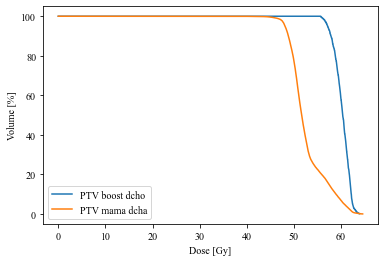

In [30]:
calcdvh14.relative_volume.plot()
calcdvh15.relative_volume.plot()

In [31]:
cdvhl = [dvhcalc.get_dvh(
    'patients/TestMamaDer001/20230116_095704/RTSTRUCT/CT/20230116_095704/RS.1.2.246.352.205.5566667512400723974.375329800850442140.dcm', 
    'patients/TestMamaDer001/20230116_095704/RTDOSE/CT/20230116_095704/RD.1.2.246.352.221.47352446189117142439988284232660965553.dcm', 
    key) for key in strs.keys()]

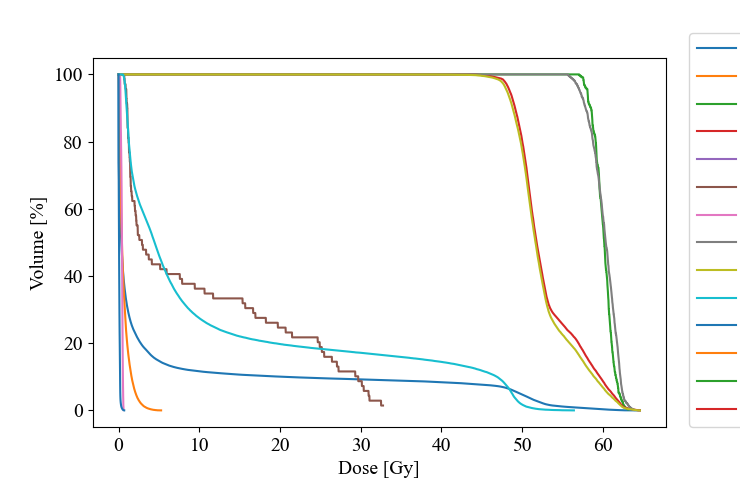

In [35]:
for cdvh in cdvhl:
    cdvh.relative_volume.plot()
plt.legend(loc=(1.04, 0))
plt.show()

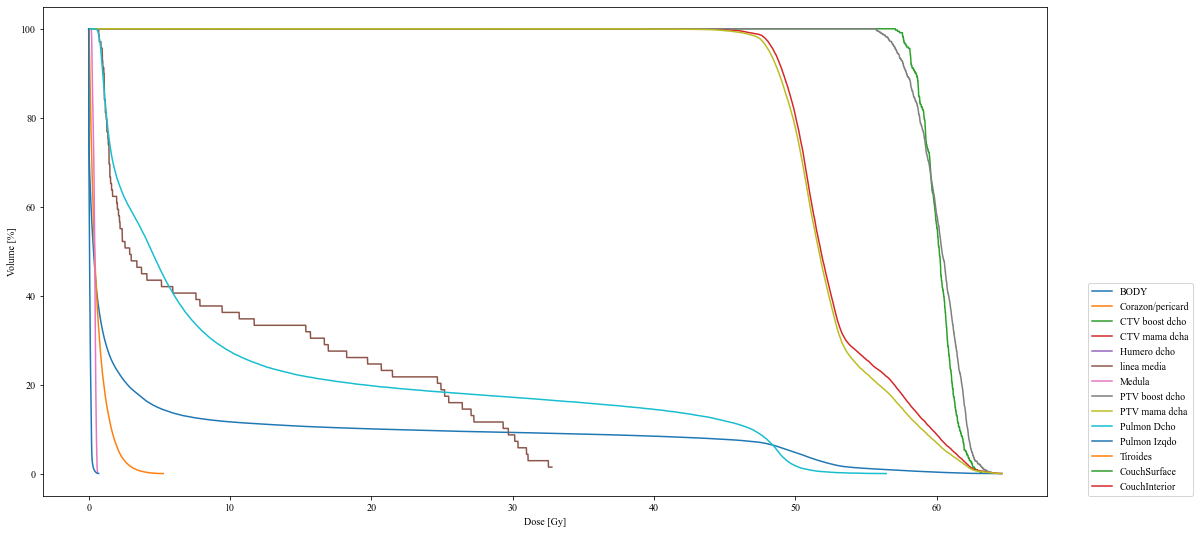

In [33]:
f = plt.figure()
f.set_figwidth(18)
f.set_figheight(9)
for cdvh in cdvhl:
    cdvh.relative_volume.plot()
plt.legend(loc=(1.04, 0))
plt.show()